In [1]:
import numpy as np
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from requests import get
import pickle
from IPython import display
from IPython.display import clear_output
%matplotlib inline

In [2]:
plt.rcParams.update({
        "pgf.texsystem": "pdflatex",
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Helvetica",
        'pgf.rcfonts': False,
    })

plt.style.use('seaborn-v0_8-ticks')

matplotlib.rcParams.update({'font.size': 18})

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                        '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                        '#bcbd22', '#17becf']

# Load learning dynamics data

<font size = "3"> Specify the necessary parameters (n, s, w) to get the appropriate data. For data with bigger d_ff or 5 digits, changes the directory accordingly. </font>

In [10]:
n = 2 # Number of layers
s = 0.3 # Train/test split
w = 0.2 # weight decay

num_ex = 6

directory = 'n{!s}_s{!s}_w{!s}/'.format(n, s, w)
Data_out = []

for p in range(num_ex):
    inputFile = 'DATA_n{!s}_s{!s}_w{!s}_{!s}.data'.format(n, s, w, p)
    inputFile = directory + inputFile
    fd = open(inputFile, 'rb')
    Data_out.append(pickle.load(fd))

T = len(Data_out[0][0])

In [8]:
def Plots_loss_acc_sqW_allmodels(Data_out, num_ex, PerTokenData = True, PerTen = False, Full_included=False, p = None):

    T = len(Data_out[0][0])

    if PerTen:
        x = np.arange(0, 10*T, 10)
    else:
        x = np.arange(0, T)

    fig, ax = plt.subplots(1, 3, figsize = (23, 6))
    fig.tight_layout(w_pad=2)

    if p is None:
        r = range(num_ex)
        rr = -1
        aa = 0.2
    else:
        r = range(p, p+1)
        rr = p
        aa = 1

    for i in r:
        ax[0].plot(x, Data_out[i][1], color=colors[1], alpha=aa)
        ax[0].plot(x, Data_out[i][0], color=colors[0], alpha=aa)
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    

    if Full_included:
        q = 2
    else: 
        q = 0
   
    if PerTokenData:
        if Full_included:
            a1 = torch.tensor([[Data_out[j][2+q][i] for i in range(T)] for j in range(num_ex)])
            a2 = torch.tensor([[Data_out[j][3+q][i] for i in range(T)] for j in range(num_ex)])
        else: 
            a1 = torch.tensor([[Data_out[j][2][i].min() for i in range(T)] for j in range(num_ex)])
            a2 = torch.tensor([[Data_out[j][3][i].min() for i in range(T)] for j in range(num_ex)])
    else: 
        a1 = torch.tensor([[Data_out[j][2][i] for i in range(T)] for j in range(num_ex)])
        a2 = torch.tensor([[Data_out[j][3][i] for i in range(T)] for j in range(num_ex)])
    # a3 = torch.tensor([[Data_out[j][6][i].item() for i in range(T)] for j in range(6)])
    # a4 = torch.tensor([[Data_out[j][7][i].item() for i in range(T)] for j in range(6)])

    props = dict(boxstyle='round', facecolor='white', alpha=1)

    for j in r:
        ax[1].plot(x, a2[j], color=colors[1], alpha=aa)
        ax[1].plot(x, a1[j], color=colors[0], alpha=aa)
        # ax[1].plot(a3[j], 'c', alpha=0.2)
        # ax[1].plot(a4[j], 'm', alpha=0.2)

    # ax[1].plot(torch.mean(a3, 0), 'c')
    # ax[1].plot(torch.mean(a4, 0), 'm')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    for i in r:
        ax[2].plot(x, Data_out[i][-1], color=colors[0], alpha=aa)
    ax[2].set_ylabel('Norm squared weights')
    ax[2].set_xlabel('Epochs')

    ## Plot Averages

    if p is None:
        ax[1].plot(x, torch.mean(a2, 0), color=colors[1])
        ax[1].plot(x, torch.mean(a1, 0), color=colors[0])
        ax[0].plot(x, np.mean(np.array([Data_out[i][1] for i in range(num_ex)]), 0), color=colors[1])
        ax[0].plot(x, np.mean(np.array([Data_out[i][0] for i in range(num_ex)]), 0), color=colors[0])
        ax[1].text(0.7, 0.8, '%1.3f' % torch.mean(a2, 0)[-1], transform=ax[1].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

        ax[2].plot(x, np.mean(np.array([Data_out[i][-1] for i in range(num_ex)]), 0), color=colors[0])

    else: 
        ax[1].text(0.7, 0.8, '%1.3f' % a2[p][-1], transform=ax[1].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    lg0 = ax[0].legend(['test', 'train'])
    lg1 = ax[1].legend(['test', 'train'])
    lgg = [lg0, lg1]

    for i in lgg:
        for lh in i.legend_handles: 
            lh.set_alpha(1)

def Individual_token_acc_per_model(Data_out, j, ndig, PerTen=False):

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica"
    })

    T = len(Data_out[0][0])

    if PerTen:
        x = np.arange(0, 10*T, 10)
    else:
        x = np.arange(0, T)

    a1 = torch.tensor([[Data_out[j][2][i][k] for i in range(T)] for k in range(ndig)])
    a2 = torch.tensor([[Data_out[j][3][i][k] for i in range(T)] for k in range(ndig)])

    fig, ax = plt.subplots(1, 2 + ndig, figsize=(23, 4))
    fig.tight_layout(w_pad=2)

    for k in range(ndig):
            
        ax[k].plot(x, a2[k, :], color=colors[1])
        ax[k].plot(x, a1[k, :], color=colors[0])
        ax[k].set_title(f'Pos. {k}')
        ax[k].set_xlabel('Epochs')
        ax[k].set_ylabel('Accuracy')
        ax[k].legend(['test', 'train'])

    ax[ndig].plot(x, Data_out[j][1], color=colors[1])
    ax[ndig].plot(x, Data_out[j][0], color=colors[0])
    ax[ndig].set_xlabel('Epochs')
    ax[ndig].set_ylabel('Loss')
    ax[ndig].set_yscale('log')
    ax[ndig].legend(['test', 'train'])

    ax[ndig + 1].plot(x, Data_out[j][-1], color=colors[0])
    ax[ndig + 1].set_xlabel('Epochs')
    ax[ndig + 1].set_ylabel('Norm squared weights')

def Task_acc_and_corr_per_model(Data_out, j, T):

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf', ]

    x = np.arange(0, T)

    a1 = torch.tensor([[[[Data_out[j][6][i][t, k] for i in range(T)] for j in range(6)] for t in range(4)] for k in range(3)])
    a2 = torch.tensor([[[[Data_out[j][7][i][t, k] for i in range(T)] for j in range(6)] for t in range(4)] for k in range(3)])

    fig, ax = plt.subplots(1, 3, figsize=(25, 6))
    for k in range(3):
        m = 0
        for t in range(4):
            ax[k].plot(x, a1[k, t, j, :], color=colors[m])
            ax[k].plot(x, a2[k, t, j, :], color=colors[m+1])
            ax[k].set_xlabel('Epochs')
            ax[k].set_ylabel('Accuracy')
            m += 2
        ax[k].set_title('Position {!s}'.format(k))
        ax[k].legend(['NC', 'NC corr', 'C@1', 'C@1 corr', 'C@2', 'C@2 corr', 'C all', 'C all corr'])

    # ax[3].plot(x, Data_out[j][0], color=colors[0])
    # ax[3].plot(x, Data_out[j][1], color=colors[1])
    # ax[3].set_xlabel('Epochs')
    # ax[3].set_ylabel('Loss')
    # ax[3].set_yscale('log')
    # ax[3].legend(['train', 'test'])

    # ax[4].plot(x, Data_out[j][-1], color=colors[0])
    # ax[4].set_xlabel('Epochs')
    # ax[4].set_ylabel('Norm weights')

# n=1, s=0.3, w=0.2, p = 0 -> Figure 2

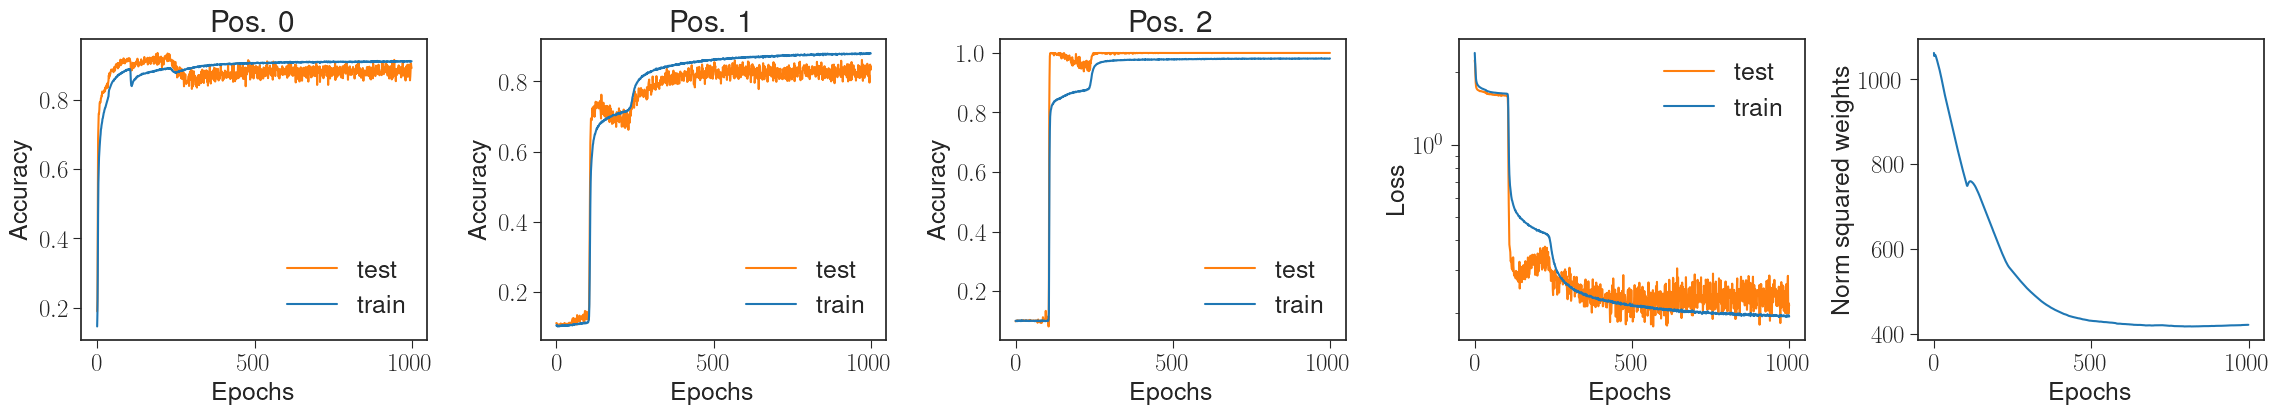

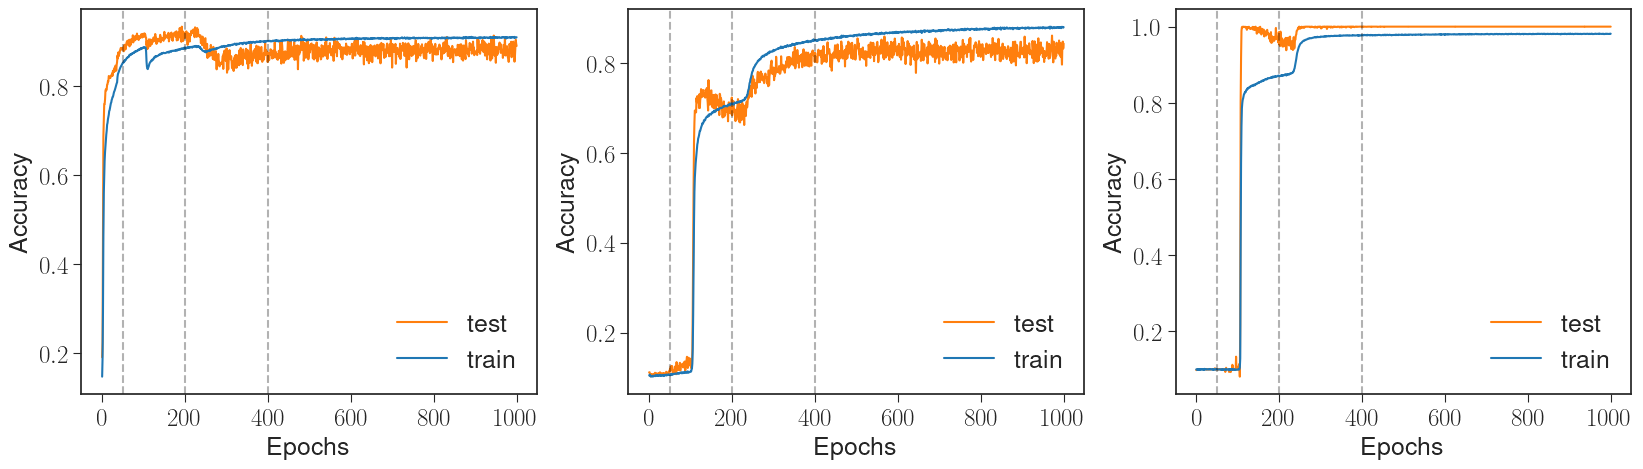

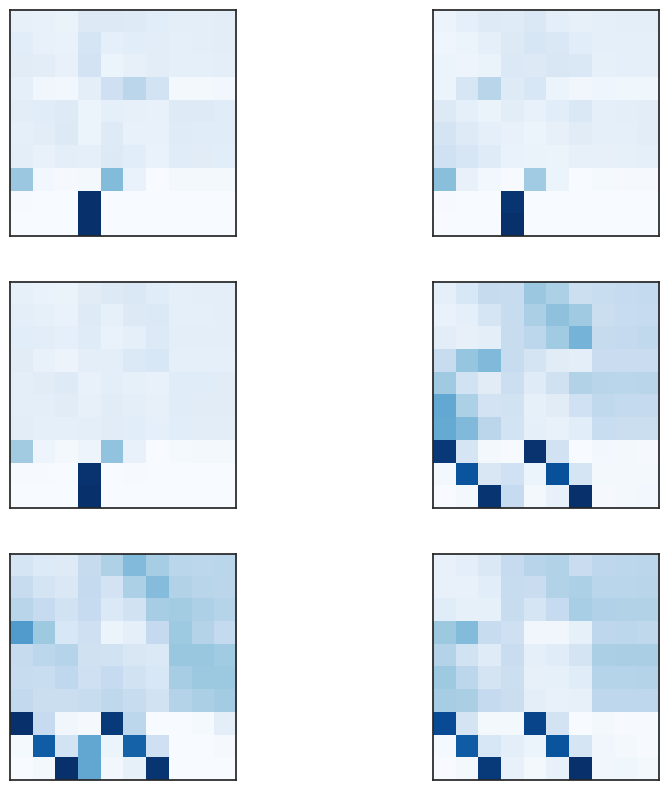

In [9]:
p = 0

Individual_token_acc_per_model(Data_out, p, ndig=3, PerTen=False)

T = len(Data_out[0][0])

x = np.arange(0, T)

a1 = torch.tensor([[Data_out[p][2][i][k] for i in range(T)] for k in range(3)])
a2 = torch.tensor([[Data_out[p][3][i][k] for i in range(T)] for k in range(3)])

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    ax[i].plot(x, a2[i, :], color=colors[1])
    ax[i].plot(x, a1[i, :], color=colors[0])
    
    ax[i].legend(['test', 'train'])
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Accuracy')

    ax[i].axvline(x=50, color='black', linestyle='--', alpha=0.3)
    ax[i].axvline(x=200, color='black', linestyle='--', alpha=0.3)
    ax[i].axvline(x=400, color='black', linestyle='--', alpha=0.3)

p = 0

fig, ax = plt.subplots(3, 2, figsize = (10, 10))

for i in range(2):
    ax[0, i].imshow(Data_out[p][-2][50][0, i, :, :], cmap='Blues')
    ax[1, i].imshow(Data_out[p][-2][200][0, i, :, :], cmap='Blues')
    ax[2, i].imshow(Data_out[p][-2][300][0, i, :, :], cmap='Blues')
    ax[0, i].set_xticks([])
    ax[1, i].set_xticks([])
    ax[2, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].set_yticks([])
    ax[2, i].set_yticks([])

# Load data: n=1, s=0.3, w=0.2 -> Figure 8

In [ ]:
Plots_loss_acc_sqW_allmodels(Data_out, num_ex=num_ex, PerTokenData = True, PerTen=False, Full_included=True)

# Load data: n=1, s=0.3, w=0.0 -> Figure 9

In [ ]:
Plots_loss_acc_sqW_allmodels(Data_out, num_ex=num_ex, PerTokenData = True, PerTen=False, Full_included=True)

# Load data: n=1, s=0.2, w=1.0, p=2 -> Figure 10

In [ ]:
p = 2

Plots_loss_acc_sqW_allmodels(Data_out, num_ex=num_ex, PerTokenData = True, PerTen=False, Full_included=True)
Individual_token_acc_per_model(Data_out, p, ndig=3, PerTen=False)

# n=2, s=0.3, w=0.2, p=2 -> Figure 11

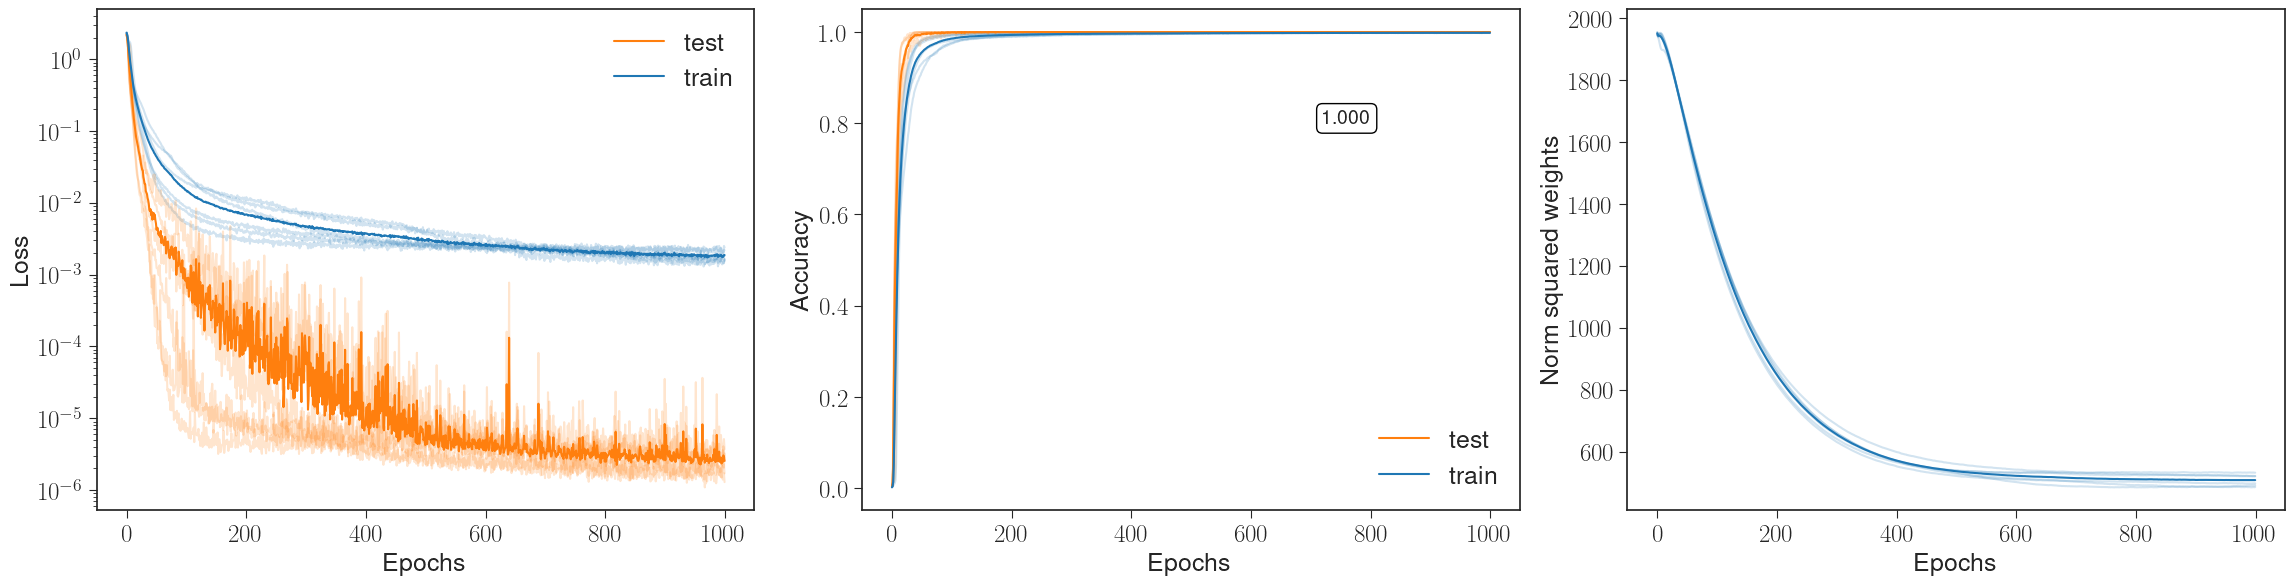

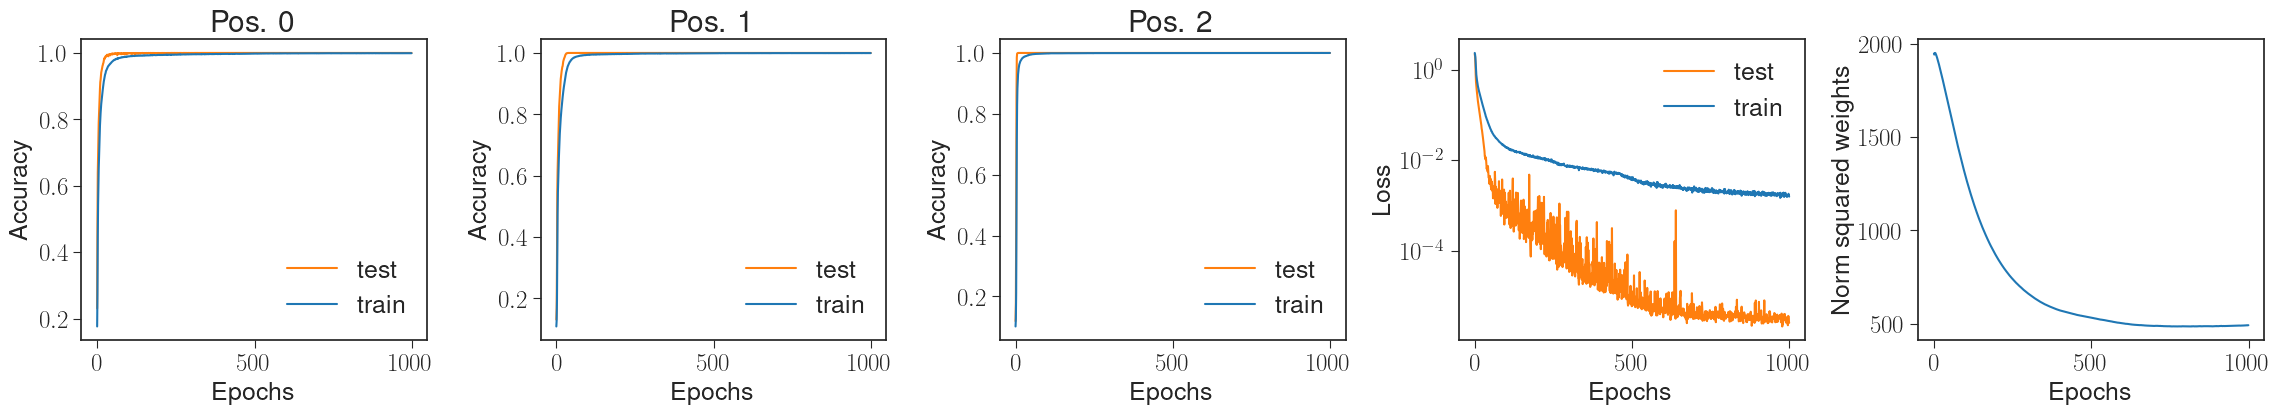

In [11]:
p = 2

Plots_loss_acc_sqW_allmodels(Data_out, num_ex=num_ex, PerTokenData = True, PerTen=False, Full_included=True)
Individual_token_acc_per_model(Data_out, p, ndig=3, PerTen=False)

# n=2, s=0.3, w=0.0 -> Figure 12

In [ ]:
Plots_loss_acc_sqW_allmodels(Data_out, num_ex=num_ex, PerTokenData = True, PerTen=False, Full_included=True)

# n=2, s=0.3, w=0.2, 5 digits -> Figure 20

In [ ]:
T = 1000

token = torch.Tensor([[[Data_out[p][-1][i][0][k] for i in range(T)] for k in range(5)] for p in range(6)])

fig, ax = plt.subplots(1, 5, figsize=(25, 4))
fig.tight_layout(w_pad=2)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

for k in range(5):
        
    for p in range(6):
        ax[k].plot(token[p, k], color = colors[p], alpha=0.3)
    ax[k].plot(token[:, k].mean(0), color = 'black')

    ax[k].set_xlabel('Epochs')
    ax[k].set_ylabel('Accuracy')

lg = fig.legend(['Model 0', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Average'], bbox_to_anchor=(1.07, 0.2), loc='lower right', borderaxespad=0.)
for handle in lg.legend_handles:
    #handle.set_sizes([10.0])
    handle.set_alpha(1)